<a href="https://colab.research.google.com/github/bajajyukta7/InsurancePolicyCopilot/blob/main/InsurancePolicy_AI_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the following packages incase they're not loaded already
!pip install pdfplumber
!pip install chromadb==0.5.3
!pip install tiktoken
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.5 MB/s eta 0:00:00

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.1 MB/s eta 0:00:00


In [1]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import chromadb
import openai

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
os.chdir('/content/drive/MyDrive/upgrad/HelpMate')
!ls

OpenAI_API_Key.txt  Principal-Sample-Life-Insurance-Policy.pdf


In [9]:
# Set the API key
filepath = "/content/drive/MyDrive/upgrad/HelpMate/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

LLM - context window

LLM(snapshot memory) --> output, question 2
LLM + external memory : added memory + added knowledge + ground your system

## Quick Recap of RAG

4 levels of application:
1. LLM (vanilla memory = context window, RAM)
2. LLM with RAG(external memory = HD )
3. LLM with function calling (RAG, tools)
4. LLM based oS (more modalities)

Quick Recap of a RAG system

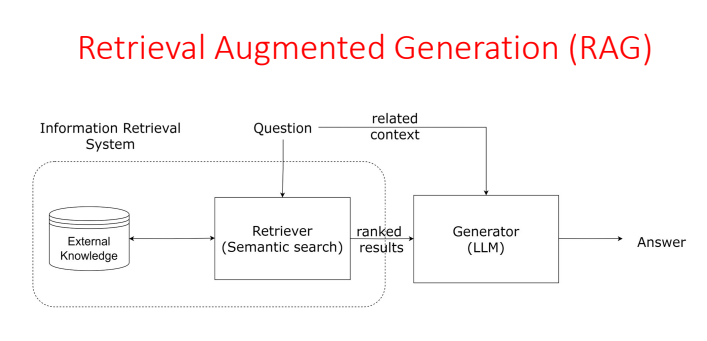

In [ ]:
## Issues with normal LLMs
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":"What is the revenue of uber in 2023?"},
          ]

In [ ]:
## New method (as older completion and chatcompletion endpoints have been deprecated)
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

"I'm sorry, but I cannot provide real-time or future revenue figures for companies such as Uber. Company financial information is usually released quarterly or annually by the company itself or through financial news sources. I recommend checking Uber's official financial reports or news updates for the most recent information on their revenue in 2023."

As you see the LLMs may not have access to your internal data, and therefore, they won't be able to **retrieve** information beyond the data that they have been trained on

However there's a trick you can use!!

Here's the relevant snippet from uber's annual filings report uber_2021. pdf page 53

*Revenue was $17.5 billion, or up 57% year-over-year, reflecting the overall growth in our Delivery business and an increase in Freight revenue attributable tothe acquisition of Transplace in the fourth quarter of 2021 as well as growth in the number of shippers and carriers on the network combined with an increase involumes with our top shippers.*

In [ ]:
retrieved = "Revenue was $17.5 billion, or up 57% year-over-year, reflecting the overall growth in our Delivery business and an increase in Freight revenue attributable tothe acquisition of Transplace in the fourth quarter of 2021 as well as growth in the number of shippers and carriers on the network combined with an increase involumes with our top shippers."

In [ ]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""What is the revenue of uber in 2021?. Use the information presented in '{retrieved}' """},
          ]

In [ ]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

'The revenue of Uber in 2021 was $17.5 billion.'

So what we did above was,
- We **retrieved** the information from an external source,
- **Augmented** our query with the relevant information prompt,
- and finally we **generated** the relevant response

This above process is RAG in a nutshell!

## Starter Code explanation

### Data Processing

Quite crucial, hence suggested to use good parsers that can load the data from your documents effectively.


In [19]:
pdf_path = "/content/drive/MyDrive/upgrad/HelpMate/"

In [20]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [21]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any([check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [22]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [23]:
data

[   Page No.                                          Page_Text  \
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
 1    Page 2                 This page left blank intentionally   
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
 3    Page 4                 This page left blank intentionally   
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
 ..      ...                                                ...   
 59  Page 60  I f a Dependent who was insured dies during th...   
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...   
 61  Page 62  A claimant may request an appeal of a claim de...   
 62  Page 63                 This page left blank intentionally   
 63  Page 64  Principal Life Insurance Company Des Moines, I...   
 
                                  Document Name  
 0   Principal-Sample-Life-Insurance-Policy.pdf  
 1   Principal-Sample-Life-Insurance-Policy.pdf  
 2   Principal-Sample-Life-Insurance-Policy.

In [24]:
insurance_policy_pdf_data = pd.concat(data, ignore_index=True)

In [25]:
insurance_policy_pdf_data.head(5)

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf


In [26]:
len(insurance_policy_pdf_data)

64

In [87]:
# Remove empty pages
insurance_policy_pdf_data = insurance_policy_pdf_data[insurance_policy_pdf_data['Page_Text'] != 'This page left blank intentionally']

In [88]:
len(insurance_policy_pdf_data)

61

In [89]:
insurance_policy_pdf_data['Metadata'] = insurance_policy_pdf_data.apply(lambda x: {'filing_name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [90]:
insurance_policy_pdf_data.head(5)

,Page No.,Page_Text,Document Name,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,{'filing_name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,{'filing_name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,{'filing_name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,{'filing_name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,{'filing_name': 'Principal-Sample-Life-Insuran...


<sentence> --[1,15,512] [batch, seq_length, emb_dim]

## Generate and Store Embeddings using OpenAI and ChromaDB
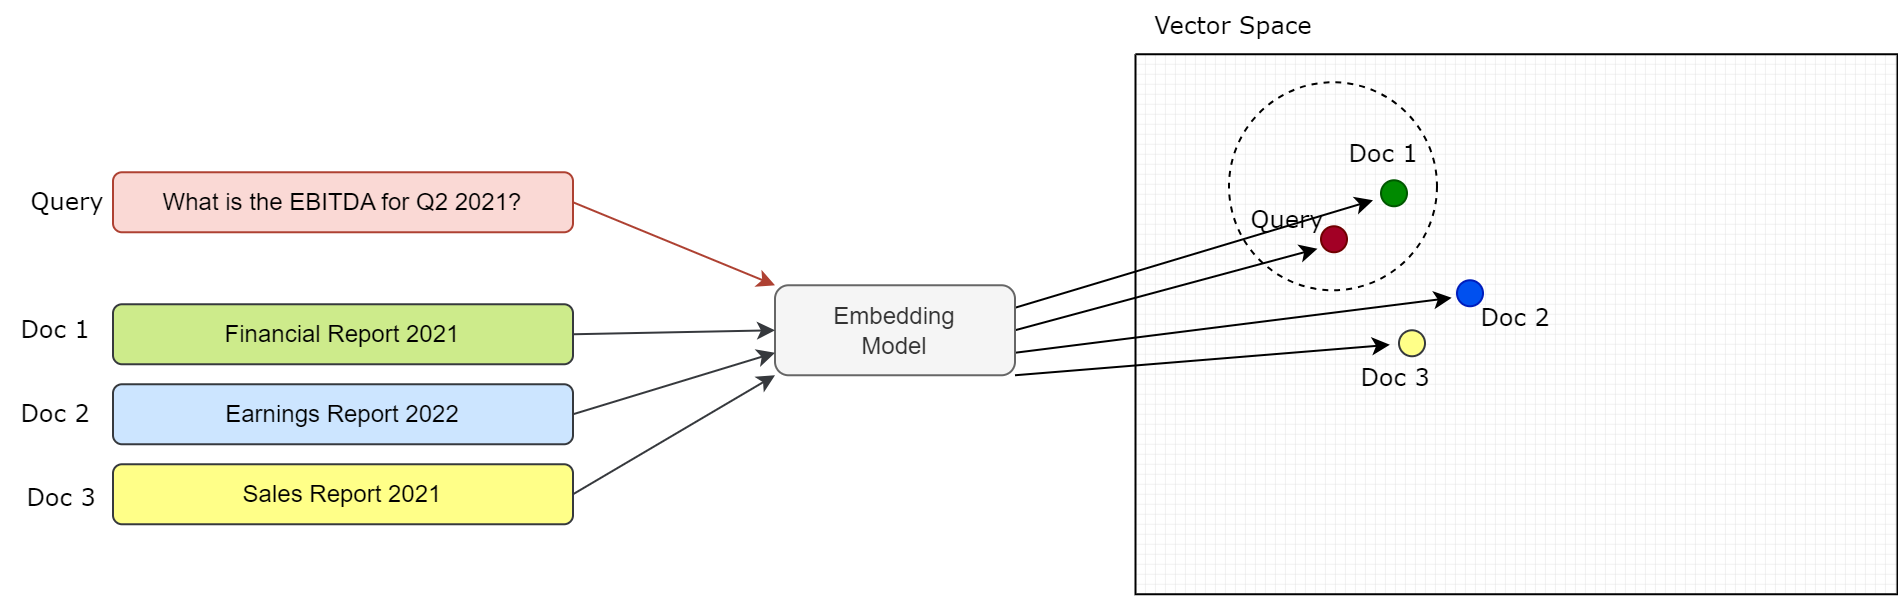

input ---> embedding model --> feature/latent vector (limited dimensions for ex)

f.v (king) f.v(man)
f.v(queen) f.v (woman)

In [91]:
# Import the OpenAI Embedding Function into chroma
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [92]:
# Define the path where chroma collections will be stored

chroma_data_path = "/content/drive/MyDrive/upgrad/HelpMate/persist_path"

In [93]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [94]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [101]:
## Create an empty collection
insurancepolicy_datacollection = client.get_or_create_collection(name='RAG', embedding_function=embedding_function)

In [102]:
documents_list = insurance_policy_pdf_data["Page_Text"].tolist()
metadata_list = insurance_policy_pdf_data['Metadata'].tolist()

In [103]:
#metadata_list

In [104]:
?insurancepolicy_datacollection

In [105]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurancepolicy_datacollection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [106]:
insurancepolicy_datacollection

In [107]:
insurancepolicy_datacollection.peek(2)

{'ids': ['0', '1'],
 'embeddings': [[-0.022594019770622253,
   0.018678244203329086,
   -0.02725379168987274,
   -0.031273987144231796,
   -0.003690617624670267,
   0.027854209765791893,
   0.000881865038536489,
   0.023755699396133423,
   -0.01670730486512184,
   0.004242089111357927,
   -0.005247137974947691,
   0.004131142050027847,
   -0.0062260814011096954,
   0.023351069539785385,
   -0.011355746537446976,
   0.030986828729510307,
   0.002793252468109131,
   -0.024812957271933556,
   0.03059525229036808,
   0.007890285924077034,
   0.00647734384983778,
   0.018821822479367256,
   0.00951533205807209,
   0.0127327935770154,
   -0.012386900372803211,
   -0.0094370162114501,
   0.01784287951886654,
   -0.021719496697187424,
   0.02358601614832878,
   0.003117935499176383,
   0.013346265070140362,
   -0.01463194377720356,
   -0.03362344950437546,
   -0.04111563414335251,
   -0.008405862376093864,
   0.013561632484197617,
   -0.0026300952304154634,
   -0.0038635642267763615,
   0.0124

In [110]:
# Let's take a look at the first few entries in the collection

insurancepolicy_datacollection.get(
   ids = ['0','1','2'],
   include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022594019770622253,
   0.018678244203329086,
   -0.02725379168987274,
   -0.031273987144231796,
   -0.003690617624670267,
   0.027854209765791893,
   0.000881865038536489,
   0.023755699396133423,
   -0.01670730486512184,
   0.004242089111357927,
   -0.005247137974947691,
   0.004131142050027847,
   -0.0062260814011096954,
   0.023351069539785385,
   -0.011355746537446976,
   0.030986828729510307,
   0.002793252468109131,
   -0.024812957271933556,
   0.03059525229036808,
   0.007890285924077034,
   0.00647734384983778,
   0.018821822479367256,
   0.00951533205807209,
   0.0127327935770154,
   -0.012386900372803211,
   -0.0094370162114501,
   0.01784287951886654,
   -0.021719496697187424,
   0.02358601614832878,
   0.003117935499176383,
   0.013346265070140362,
   -0.01463194377720356,
   -0.03362344950437546,
   -0.04111563414335251,
   -0.008405862376093864,
   0.013561632484197617,
   -0.0026300952304154634,
   -0.0038635642267763615,
   0

In [111]:
cache_collection01 = client.get_or_create_collection(name='InsurancePolicy_Cache01', embedding_function=embedding_function)

In [112]:
cache_collection01.peek()

{'ids': ['what all benifits does my insurance policy have?'],
 'embeddings': [[-0.014197384007275105,
   -0.0021627757232636213,
   0.030747320502996445,
   -0.04549181088805199,
   -0.022704871371388435,
   0.017288528382778168,
   -0.033017806708812714,
   -0.0198736023157835,
   -0.028476832434535027,
   0.015770312398672104,
   -3.261795063735917e-05,
   0.026685062795877457,
   -0.005990803707391024,
   0.017083363607525826,
   -0.005142790265381336,
   0.014881265349686146,
   0.023429786786437035,
   -0.00534453522413969,
   0.014949653297662735,
   -0.007454310078173876,
   -0.0008958849939517677,
   0.002191840671002865,
   0.002925303764641285,
   0.0004402488411869854,
   0.0037374133244156837,
   -0.008842590264976025,
   0.024824904277920723,
   0.0019849666859954596,
   0.005546280182898045,
   -0.005501828156411648,
   0.039966046810150146,
   0.020489094778895378,
   -0.0460389144718647,
   -0.00507440185174346,
   0.004127225838601589,
   0.016796134412288666,
   0.009

## Semantic Search with Cache

We have created 2 collections
- insurancepolicy_collection (embeddings are already present)
- cache_collection (an empty collection at the beginning)

Our strategy is to first check the cache_collection and see if can answer the query or not.

In case it doesn't the query then passes to the financedata_collection, and the query results get appended to cache_collection (embeddings, metadata, etc)

Semantic Search Pipeline

In [119]:
# Read the user query
query = input()

what is biggest benefit of your insurance policy?


In [120]:
query

'what is biggest benefit of your insurance policy?'

In [121]:
## Quickly checking the results of the query
results = insurancepolicy_datacollection.query(
      query_texts=query,
      n_results=10
      )

In [122]:
results

{'ids': [['54', '45', '16', '2', '53', '29', '17', '7', '46', '31']],
 'distances': [[0.39968020469558485,
   0.41862388320887706,
   0.4203663232388898,
   0.4248933739303051,
   0.4272793962505978,
   0.4291793316671352,
   0.42931564925256555,
   0.43043960757559174,
   0.4371782836868715,
   0.43861479743868287]],
 'metadatas': [[{'Page_No.': 'Page 55',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 46',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 17',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 3',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 54',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 30',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 18',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 8',
    'filing_name': 

In [123]:
for key, val in results.items():
  print(key)

ids
distances
metadatas
embeddings
documents
uris
data
included


In [124]:
for key, val in results.items():
  print(key)
  print(val)

ids
[['54', '45', '16', '2', '53', '29', '17', '7', '46', '31']]
distances
[[0.39968020469558485, 0.41862388320887706, 0.4203663232388898, 0.4248933739303051, 0.4272793962505978, 0.4291793316671352, 0.42931564925256555, 0.43043960757559174, 0.4371782836868715, 0.43861479743868287]]
metadatas
[[{'Page_No.': 'Page 55', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 46', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 17', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 3', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 54', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 30', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 18', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 8', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 47', 'filing_name': 'Principal-S

In [125]:
results

{'ids': [['54', '45', '16', '2', '53', '29', '17', '7', '46', '31']],
 'distances': [[0.39968020469558485,
   0.41862388320887706,
   0.4203663232388898,
   0.4248933739303051,
   0.4272793962505978,
   0.4291793316671352,
   0.42931564925256555,
   0.43043960757559174,
   0.4371782836868715,
   0.43861479743868287]],
 'metadatas': [[{'Page_No.': 'Page 55',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 46',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 17',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 3',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 54',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 30',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 18',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 8',
    'filing_name': 

In [126]:
for key, val in results.items():
  if key not in ['embeddings', 'uris','data']:
    for i in range(10):
      print(str(key)+str(i))


ids0
ids1
ids2
ids3
ids4
ids5
ids6
ids7
ids8
ids9
distances0
distances1
distances2
distances3
distances4
distances5
distances6
distances7
distances8
distances9
metadatas0
metadatas1
metadatas2
metadatas3
metadatas4
metadatas5
metadatas6
metadatas7
metadatas8
metadatas9
documents0
documents1
documents2
documents3
documents4
documents5
documents6
documents7
documents8
documents9
included0
included1
included2
included3
included4
included5
included6
included7
included8
included9


Building the cache

In [154]:
# Read the user query
query = input()

what are the benefits in case of disability?


In [155]:
# Searh the Cache collection first
# Query the collection against the user query and return the top result

cache_results = cache_collection01.query(
    query_texts=query,
    n_results=1
)

In [156]:
cache_results

{'ids': [['what all benifits does my insurance policy have?']],
 'distances': [[0.3055563787941417]],
 'metadatas': [[{'distances0': '0.36350610704340064',
    'distances1': '0.3836798349932639',
    'distances2': '0.39215975653727864',
    'distances3': '0.3962139492769268',
    'distances4': '0.40576177401364405',
    'distances5': '0.40957776531441575',
    'distances6': '0.4101868271123344',
    'distances7': '0.4109992482883531',
    'distances8': '0.41226108809494544',
    'documents0': 'Exposure Exposure to the elements will be presumed to be an injury if: a. such exposure is due to an accidental bodily injury; and b. within 365 days after the injury, the Member incurs a loss that is the result of the exposure; and c. this Group Policy would have covered the injury resulting from the accident. Article 4 - Seat Belt/Airbag Benefit If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $1

In [157]:
cache_results['distances'][0][0]

0.3055563787941417

In [158]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurancepolicy_datacollection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if key not in ['embeddings', 'uris','data']:
          for i in range(9):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


      cache_collection01.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Not found in cache. Found in main collection.


In [159]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 49', 'filing_name': 'Princi...",Payment of benefits will be subject to the Ben...,0.345829,48
1,"{'Page_No.': 'Page 51', 'filing_name': 'Princi...",Coverage During Disability will cease on the e...,0.349917,50
2,"{'Page_No.': 'Page 56', 'filing_name': 'Princi...","If a Member sustains an injury, and as a resul...",0.363736,55
3,"{'Page_No.': 'Page 50', 'filing_name': 'Princi...",The Principal may require that a ADL Disabled ...,0.364314,49
4,"{'Page_No.': 'Page 54', 'filing_name': 'Princi...","f . claim requirements listed in PART IV, Sect...",0.377884,53
5,"{'Page_No.': 'Page 8', 'filing_name': 'Princip...",Section A - Member Life Insurance Schedule of ...,0.381140,7
6,"{'Page_No.': 'Page 55', 'filing_name': 'Princi...",Exposure Exposure to the elements will be pres...,0.381769,54
7,"{'Page_No.': 'Page 38', 'filing_name': 'Princi...",Section D - Continuation Article 1 - Member Li...,0.389229,37
8,"{'Page_No.': 'Page 57', 'filing_name': 'Princi...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.389713,56
9,"{'Page_No.': 'Page 32', 'filing_name': 'Princi...",(1) marriage or establishment of a Civil Union...,0.394265,31


In [160]:
## Checking if the cache also contains the results
cache_results = cache_collection01.query(
    query_texts=query,
    n_results=1
)
cache_results

{'ids': [['what are the benefits in case of disability?']],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.3458288803245592',
    'distances1': '0.34991720706026214',
    'distances2': '0.3637355073281272',
    'distances3': '0.36431351733573075',
    'distances4': '0.3778838216061889',
    'distances5': '0.38113974820902585',
    'distances6': '0.38176877649579966',
    'distances7': '0.3892285733357429',
    'distances8': '0.3897134041518834',
    'documents0': "Payment of benefits will be subject to the Beneficiary and Facility of Payment provisions of this PART IV, Section A. Article 6 - Member Life Insurance - Coverage During Disability A Member may be eligible to continue his or her Member Life and Member Accidental Death and Dismemberment Insurance and Dependent Life Insurance coverage during the Member's ADL Disability or Total Disability. a. Coverage Qualification To be qualified for Coverage During Disability, a Member must: (1) become ADL Disabled or Totally Disabl

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

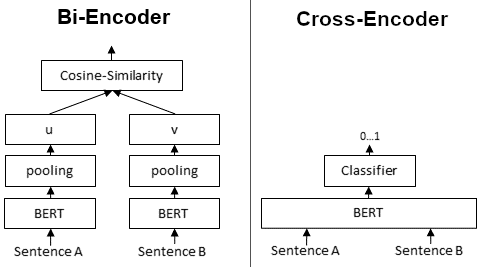

<br>

In [133]:
!pip install sentence_transformers

In [134]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [135]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [161]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [162]:
scores

array([  3.8467617, -11.252879 ], dtype=float32)

In [163]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [164]:
 #Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [165]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 49', 'filing_name': 'Princi...",Payment of benefits will be subject to the Ben...,0.345829,48,-1.767809
1,"{'Page_No.': 'Page 51', 'filing_name': 'Princi...",Coverage During Disability will cease on the e...,0.349917,50,-1.740765
2,"{'Page_No.': 'Page 56', 'filing_name': 'Princi...","If a Member sustains an injury, and as a resul...",0.363736,55,-7.227498
3,"{'Page_No.': 'Page 50', 'filing_name': 'Princi...",The Principal may require that a ADL Disabled ...,0.364314,49,-2.450907
4,"{'Page_No.': 'Page 54', 'filing_name': 'Princi...","f . claim requirements listed in PART IV, Sect...",0.377884,53,-7.075003
5,"{'Page_No.': 'Page 8', 'filing_name': 'Princip...",Section A - Member Life Insurance Schedule of ...,0.381140,7,-4.777192
6,"{'Page_No.': 'Page 55', 'filing_name': 'Princi...",Exposure Exposure to the elements will be pres...,0.381769,54,-7.510617
7,"{'Page_No.': 'Page 38', 'filing_name': 'Princi...",Section D - Continuation Article 1 - Member Li...,0.389229,37,-7.202056
8,"{'Page_No.': 'Page 57', 'filing_name': 'Princi...",% of Scheduled Covered Loss Benefit Loss of Sp...,0.389713,56,-7.762525
9,"{'Page_No.': 'Page 32', 'filing_name': 'Princi...",(1) marriage or establishment of a Civil Union...,0.394265,31,-8.615777


In [166]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 49', 'filing_name': 'Princi...",Payment of benefits will be subject to the Ben...,0.345829,48,-1.767809
1,"{'Page_No.': 'Page 51', 'filing_name': 'Princi...",Coverage During Disability will cease on the e...,0.349917,50,-1.740765
2,"{'Page_No.': 'Page 56', 'filing_name': 'Princi...","If a Member sustains an injury, and as a resul...",0.363736,55,-7.227498


In [167]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [168]:
top_3_RAG

,Documents,Metadatas
1,Coverage During Disability will cease on the e...,"{'Page_No.': 'Page 51', 'filing_name': 'Princi..."
0,Payment of benefits will be subject to the Ben...,"{'Page_No.': 'Page 49', 'filing_name': 'Princi..."
3,The Principal may require that a ADL Disabled ...,"{'Page_No.': 'Page 50', 'filing_name': 'Princi..."


In [169]:
# Now let's define a function for fetching top 3 RAGs for different queries.
def get_top3_rag(query):
  # Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
  # Generate the cross_encoder scores for these pairs

  cross_inputs = [[query, response] for response in results_df['Documents']]
  cross_rerank_scores = cross_encoder.predict(cross_inputs)

   #Store the rerank_scores in results_df

  results_df['Reranked_scores'] = cross_rerank_scores

  # Return the top 3 results after reranking

  top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
  top_3_rerank[:3]
  top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
  return top_3_RAG

In [170]:
top_3_RAG = get_top3_rag(query)
top_3_RAG

,Documents,Metadatas
1,Coverage During Disability will cease on the e...,"{'Page_No.': 'Page 51', 'filing_name': 'Princi..."
0,Payment of benefits will be subject to the Ben...,"{'Page_No.': 'Page 49', 'filing_name': 'Princi..."
3,The Principal may require that a ADL Disabled ...,"{'Page_No.': 'Page 50', 'filing_name': 'Princi..."


In [171]:
top_3_RAG['Documents'].iloc[0]

"Coverage During Disability will cease on the earliest of: (1) the date the Member's Total Disability ends; or (2) the date the Member fails to send The Principal any required proof of ADL Disability or Total Disability; or (3) the date the Member ceases to be under the regular care and attendance of a Physician; or (4) the date the Member fails to submit to a required Medical Examination or Evaluation; or (5) the date the Member attains age 70. g. Limitations No benefits will be paid for any disability that: (1) results from willful self-injury or self-destruction, while sane or insane; or (2) results from war or act of war; or (3) results from voluntary participation in an assault, felony, criminal activity, insurrection, or riot. Article 7 - Accelerated Benefits a. Accelerated Benefits Qualification To be qualified for an Accelerated Benefit payment, a Member must: (1) be Terminally Ill and insured for a Member Life Insurance benefit of at least $10,000; and (2) send a request for A

## Build the RAG system

In [187]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, top_3_RAG):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature = 0.4
    )

    return response.choices[0].message.content.split('\n')

In [194]:
from rich.console import Console
input_cnt = 0;
while(input_cnt<3):



  console = Console()
  console.print(f"Enter your query {input_cnt + 1}:", style="green")
  query = input()
  console.print(f"Getting answer for: '{query}'", style="italic dim")

  top_3_RAG = get_top3_rag(query)
  # Generate the response
  response = generate_response(query, top_3_RAG)

  console.print(f"Response:", style="cyan")
  # Print the response
  console.print("\n".join(response))

  input_cnt+=1


Enter your query 1:

Can a dependent be added later in the policy?


Getting answer for: 'Can a dependent be added later in the policy?'

Response:

Yes, a dependent can be added later in the policy. The specific process and requirements for adding a dependent 
later in the policy may vary depending on the insurance provider and the type of policy you have. It's recommended 
to refer to the policy document for detailed instructions on how to add a dependent.

Here are the relevant policy names and page numbers for further reference:
1. Policy Name: Principal Policy
   Page Number: Page 32

2. Policy Name: Principal Policy
   Page Number: Page 38

If you need more detailed information on adding a dependent to your policy, please refer to the sections mentioned 
in the cited policy documents.

Enter your query 2:

Does this policy provide disability benefits?


Getting answer for: 'Does this policy provide disability benefits?'

Response:

Yes, the policy does provide disability benefits. The document mentions that "Coverage During Disability will cease
on the e..." and "The Principal may require that a ADL Disabled ..." which indicates the provision of disability 
benefits.

Here is the relevant information from the policy document:

| Policy Name       | Page Number |
|-------------------|-------------|
| Principal Policy  | Page 51     |
| Principal Policy  | Page 50     |

Citations:
1. Principal Policy, Page 51
2. Principal Policy, Page 50

Enter your query 3:

Does this policy provide any accidental death benefits?


Getting answer for: 'Does this policy provide any accidental death benefits?'

Response:

Yes, the policy provides accidental death benefits. The details of the accidental death benefits can be found in 
the policy document on Page 55 under the section titled "Exposure to the elements will be pres...".

Citation:
- Policy Name: Principal Insurance Policy
- Page Number: Page 55